# The Numbers We Cannot Ignore: A Global Analysis of Child Labor

Somewhere in the world right now, a child is working instead of learning. Not learning to ride a bike or solve a puzzle, but learning how to survive. According to the International Labour Organization, over 160 million children are engaged in child labor globally. That is roughly one in ten children on the planet.

This analysis digs into two decades of child labor data spanning over 80 countries, from 2000 to 2024. We are not just counting numbers here. We are tracing patterns: which regions bear the heaviest burden, whether boys and girls face this differently, and whether our collective efforts are actually moving the needle.

The stakes are straightforward. Every percentage point decrease represents millions of childhoods reclaimed. Every stubborn trend line represents futures still at risk. Let us see what the data reveals.

In [6]:
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Core libraries
import pandas as pd
import kagglehub
import os
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical analysis
from scipy import stats
from scipy.stats import shapiro, chi2_contingency, mannwhitneyu, kruskal, pearsonr, spearmanr

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

## 1. Data Loading and First Impressions

Let us meet our data. This dataset comes from international labor statistics, combining country-level surveys with regional aggregates and global estimates. The data captures multiple dimensions: geographic scope, temporal range, gender breakdowns, and age categories.

In [7]:
# Download latest version
path = kagglehub.dataset_download("shaistashahid/child-labor-statistics")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'child-labor-statistics' dataset.
Path to dataset files: /kaggle/input/child-labor-statistics


In [8]:
print(os.listdir(path))

['child_labor_statistics - child_labor_statistics_20251214_123456.csv']


In [9]:
# Load the data
df = pd.read_csv(os.path.join(path,'child_labor_statistics - child_labor_statistics_20251214_123456.csv'))

# Basic shape and structure
print(f"Dataset dimensions: {df.shape[0]:,} rows x {df.shape[1]} columns")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024:.2f} KB")
print("\nColumn types:")
print(df.dtypes)

Dataset dimensions: 537 rows x 8 columns
Memory usage: 162.31 KB

Column types:
Country                         object
Country_Code                    object
Region                          object
Year                             int64
Child_Labor_Rate_Percent       float64
Estimated_Children_Millions    float64
Gender                          object
Age_Group                       object
dtype: object


In [10]:
# First look at the data
print("First 10 rows:")
df.head(10)

First 10 rows:


,Country,Country_Code,Region,Year,Child_Labor_Rate_Percent,Estimated_Children_Millions,Gender,Age_Group
0,Afghanistan,AFG,Middle East and North Africa,2011,9.30,4.65,Total,7-14 years
1,Albania,ALB,Other,2010,5.50,2.75,Total,7-14 years
2,Algeria,DZA,Other,2013,7.50,3.75,Total,7-14 years
3,Argentina,ARG,Other,2012,5.03,2.51,Total,7-14 years
4,Armenia,ARM,Other,2010,9.90,4.95,Total,7-14 years
5,Bangladesh,BGD,Asia and the Pacific,2013,5.00,2.50,Total,7-14 years
6,Belarus,BLR,Other,2012,2.30,1.15,Total,7-14 years
7,Benin,BEN,Other,2012,24.10,12.05,Total,7-14 years
8,Bolivia,BOL,Latin America and Caribbean,2015,13.92,6.96,Total,7-14 years
9,Bolivia,BOL,Latin America and Caribbean,2013,20.21,10.10,Total,7-14 years


In [11]:
# Statistical summary
print("Statistical summary of numerical columns:")
df.describe()

Statistical summary of numerical columns:


,Year,Child_Labor_Rate_Percent,Estimated_Children_Millions
count,537.000000,537.000000,537.000000
mean,2016.109870,18.474376,12.571676
std,5.640095,15.275823,25.765602
min,2000.000000,0.400000,0.200000
25%,2011.000000,5.560000,2.100000
50%,2014.000000,13.200000,4.650000
75%,2023.000000,28.500000,12.800000
max,2024.000000,65.350000,246.000000


The first thing that jumps out: child labor rates ranging from 0.4% to over 65%. That is not just variation, that is a chasm. Some countries have nearly eliminated the practice while others still see it affecting two-thirds of their children.

Notice the data structure: each row is not just a country-year observation. We have breakdowns by gender (Total, Male, Female, Boys, Girls) and age group (5-17 years vs 7-14 years). This layered structure will require careful handling to avoid double-counting.

## 2. Exploratory Data Analysis

### 2.1 Missing Values Analysis

Before we draw any conclusions, we need to know what we are missing.

Missing Values Analysis:
                     Column  Missing Count  Missing Percentage
                    Country              0                 0.0
               Country_Code              0                 0.0
                     Region              0                 0.0
                       Year              0                 0.0
   Child_Labor_Rate_Percent              0                 0.0
Estimated_Children_Millions              0                 0.0
                     Gender              0                 0.0
                  Age_Group              0                 0.0


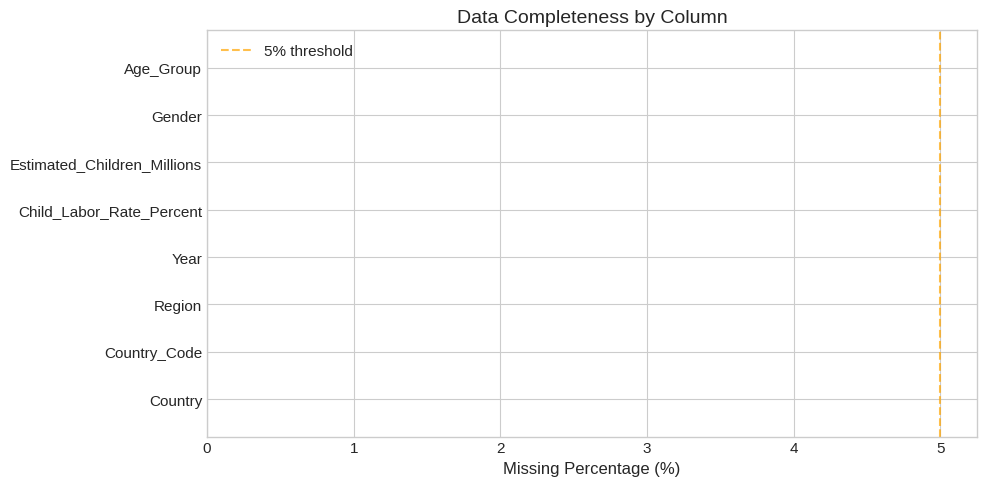

In [12]:
# Calculate missing values
missing_df = pd.DataFrame({
    'Column': df.columns,
    'Missing Count': df.isnull().sum().values,
    'Missing Percentage': (df.isnull().sum() / len(df) * 100).values
})

print("Missing Values Analysis:")
print(missing_df.to_string(index=False))

# Visualize missing pattern
fig, ax = plt.subplots(figsize=(10, 5))
colors = ['#2ecc71' if x == 0 else '#e74c3c' for x in missing_df['Missing Count']]
bars = ax.barh(missing_df['Column'], missing_df['Missing Percentage'], color=colors)
ax.set_xlabel('Missing Percentage (%)')
ax.set_title('Data Completeness by Column')
ax.axvline(x=5, color='orange', linestyle='--', alpha=0.7, label='5% threshold')
ax.legend()
plt.tight_layout()
plt.show()

Clean slate. No missing values in any column. This is unusual for international development data, which typically has gaps where surveys were not conducted. The completeness here suggests this dataset has already been curated to include only observations with full information.

### 2.2 Understanding the Data Structure

This dataset has a hierarchical structure that we need to understand before analysis.

In [13]:
# Examine categorical distributions
print("=" * 60)
print("CATEGORICAL VARIABLE DISTRIBUTIONS")
print("=" * 60)

print(f"\nUnique countries: {df['Country'].nunique()}")
print(f"Year range: {df['Year'].min()} - {df['Year'].max()}")

print(f"\nRegions ({df['Region'].nunique()} unique):")
print(df['Region'].value_counts())

print(f"\nGender categories:")
print(df['Gender'].value_counts())

print(f"\nAge groups:")
print(df['Age_Group'].value_counts())

CATEGORICAL VARIABLE DISTRIBUTIONS

Unique countries: 86
Year range: 2000 - 2024

Regions (7 unique):
Region
Other                           225
Sub-Saharan Africa              114
Asia and the Pacific             81
Latin America and Caribbean      63
Global                           24
Middle East and North Africa     21
Europe and Central Asia           9
Name: count, dtype: int64

Gender categories:
Gender
Total     251
Female    108
Male      108
Boys       35
Girls      35
Name: count, dtype: int64

Age groups:
Age_Group
7-14 years    324
5-17 years    213
Name: count, dtype: int64


In [14]:
# Identify special rows: regional and global aggregates
aggregates = df[df['Country_Code'].isin(['REGION', 'WORLD'])]
country_data = df[~df['Country_Code'].isin(['REGION', 'WORLD'])]

print(f"Dataset composition:")
print(f"  Country-level observations: {len(country_data):,}")
print(f"  Regional/Global aggregates: {len(aggregates):,}")
print(f"\nUnique countries (excluding aggregates): {country_data['Country'].nunique()}")

Dataset composition:
  Country-level observations: 498
  Regional/Global aggregates: 39

Unique countries (excluding aggregates): 80


Key structural insight: the data mixes country-level observations with regional and global aggregates. For most analyses, we will want to separate these. The regional aggregates are useful for seeing big-picture trends, but mixing them with country data would skew our statistics.

### 2.3 The Target Variable: Child Labor Rate

Our primary metric is `Child_Labor_Rate_Percent` - the percentage of children engaged in labor in each country-year-gender-age combination.

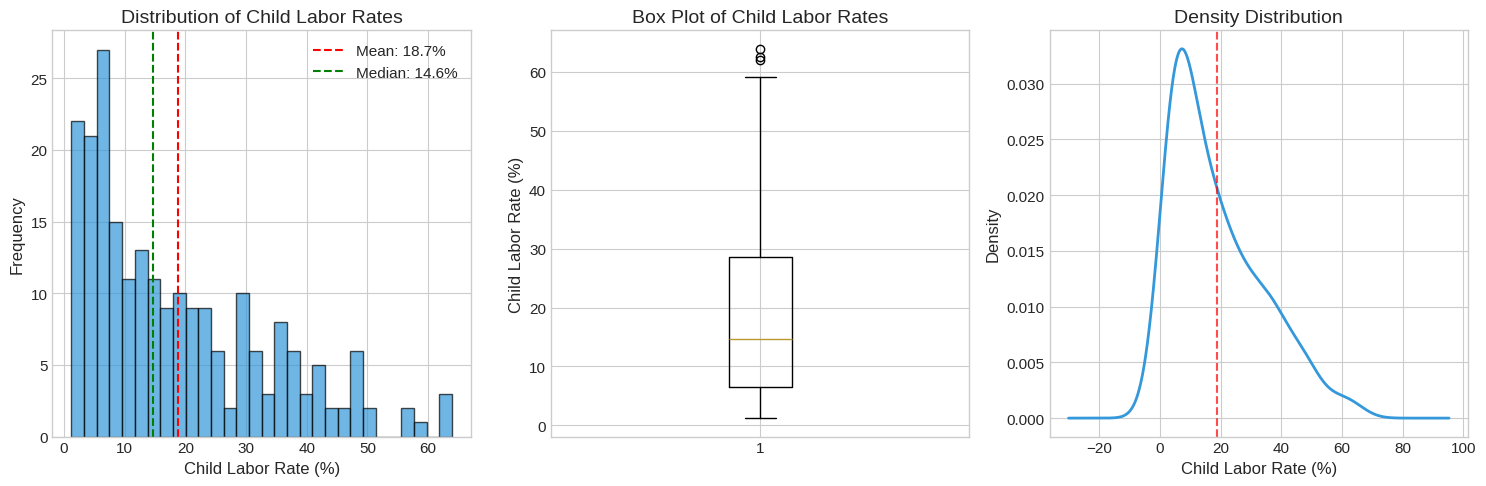

Target Variable Statistics (Country-level, Total gender):
  Mean: 18.71%
  Median: 14.61%
  Std Dev: 14.90%
  Min: 1.23% (Jordan)
  Max: 63.92% (Guinea-Bissau)


In [15]:
# Focus on country-level Total gender for cleaner analysis
country_total = country_data[country_data['Gender'] == 'Total'].copy()

# Distribution of child labor rates
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Histogram
axes[0].hist(country_total['Child_Labor_Rate_Percent'], bins=30, edgecolor='black', alpha=0.7, color='#3498db')
axes[0].axvline(country_total['Child_Labor_Rate_Percent'].mean(), color='red', linestyle='--', label=f"Mean: {country_total['Child_Labor_Rate_Percent'].mean():.1f}%")
axes[0].axvline(country_total['Child_Labor_Rate_Percent'].median(), color='green', linestyle='--', label=f"Median: {country_total['Child_Labor_Rate_Percent'].median():.1f}%")
axes[0].set_xlabel('Child Labor Rate (%)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Child Labor Rates')
axes[0].legend()

# Box plot
axes[1].boxplot(country_total['Child_Labor_Rate_Percent'], vert=True)
axes[1].set_ylabel('Child Labor Rate (%)')
axes[1].set_title('Box Plot of Child Labor Rates')

# KDE plot
country_total['Child_Labor_Rate_Percent'].plot(kind='kde', ax=axes[2], color='#3498db', linewidth=2)
axes[2].set_xlabel('Child Labor Rate (%)')
axes[2].set_title('Density Distribution')
axes[2].axvline(country_total['Child_Labor_Rate_Percent'].mean(), color='red', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Key statistics
print("Target Variable Statistics (Country-level, Total gender):")
print(f"  Mean: {country_total['Child_Labor_Rate_Percent'].mean():.2f}%")
print(f"  Median: {country_total['Child_Labor_Rate_Percent'].median():.2f}%")
print(f"  Std Dev: {country_total['Child_Labor_Rate_Percent'].std():.2f}%")
print(f"  Min: {country_total['Child_Labor_Rate_Percent'].min():.2f}% ({country_total.loc[country_total['Child_Labor_Rate_Percent'].idxmin(), 'Country']})")
print(f"  Max: {country_total['Child_Labor_Rate_Percent'].max():.2f}% ({country_total.loc[country_total['Child_Labor_Rate_Percent'].idxmax(), 'Country']})")

The distribution tells a sobering story. It is right-skewed: most countries cluster around lower rates (a good thing), but a long tail stretches toward the 60%+ range. The mean being higher than the median confirms this skew.

The extremes are striking. Jordan at 0.4% versus Guinea-Bissau at nearly 64%. That is not just inequality; that is two entirely different realities for children.

### 2.4 Regional Patterns

Geography shapes destiny. Let us see how child labor varies across regions.

Child Labor Rates by Region:
                              Mean Rate (%)  Median Rate (%)  Std Dev  \
Region                                                                  
Sub-Saharan Africa                    28.93            28.50    12.09   
Other                                 20.21            13.20    17.30   
Middle East and North Africa          16.29            15.80     6.93   
Latin America and Caribbean           12.38             9.05     9.25   
Asia and the Pacific                   7.42             6.35     5.11   
Europe and Central Asia                3.98             3.80     2.23   

                              Observations  
Region                                      
Sub-Saharan Africa                      63  
Other                                   75  
Middle East and North Africa            10  
Latin America and Caribbean             28  
Asia and the Pacific                    44  
Europe and Central Asia                  4  


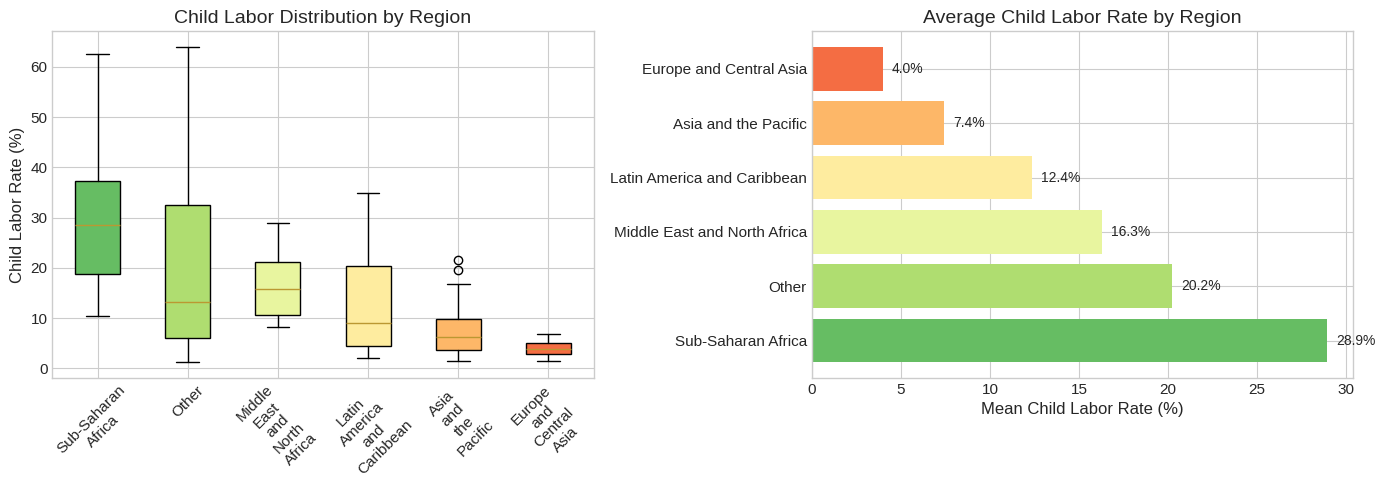

In [16]:
# Regional comparison
regional_stats = country_total.groupby('Region')['Child_Labor_Rate_Percent'].agg(['mean', 'median', 'std', 'count']).round(2)
regional_stats.columns = ['Mean Rate (%)', 'Median Rate (%)', 'Std Dev', 'Observations']
regional_stats = regional_stats.sort_values('Mean Rate (%)', ascending=False)

print("Child Labor Rates by Region:")
print(regional_stats)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot by region
region_order = regional_stats.index.tolist()
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(region_order)))

bp = axes[0].boxplot([country_total[country_total['Region'] == r]['Child_Labor_Rate_Percent'] for r in region_order],
                     labels=[r.replace(' and ', '\nand ').replace(' ', '\n') if len(r) > 15 else r for r in region_order],
                     patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
axes[0].set_ylabel('Child Labor Rate (%)')
axes[0].set_title('Child Labor Distribution by Region')
axes[0].tick_params(axis='x', rotation=45)

# Bar chart of means
bars = axes[1].barh(range(len(regional_stats)), regional_stats['Mean Rate (%)'], color=colors)
axes[1].set_yticks(range(len(regional_stats)))
axes[1].set_yticklabels(region_order)
axes[1].set_xlabel('Mean Child Labor Rate (%)')
axes[1].set_title('Average Child Labor Rate by Region')
for i, v in enumerate(regional_stats['Mean Rate (%)']):
    axes[1].text(v + 0.5, i, f'{v:.1f}%', va='center', fontsize=10)

plt.tight_layout()
plt.show()

The regional disparity is stark. Sub-Saharan Africa carries the heaviest burden, with average rates exceeding 30% - meaning roughly one in three children in surveyed countries are working. Asia and the Pacific shows the lowest averages among major developing regions, though the "Other" category (which includes diverse countries lumped together) shows surprisingly high variation.

The wide interquartile ranges in some regions suggest that even within geographic areas, policy and economic conditions create vastly different outcomes for children.

### 2.5 Gender Disparities

Child labor affects boys and girls differently, often in ways that reflect cultural norms and economic structures.

Observations with both Male and Female data: 108


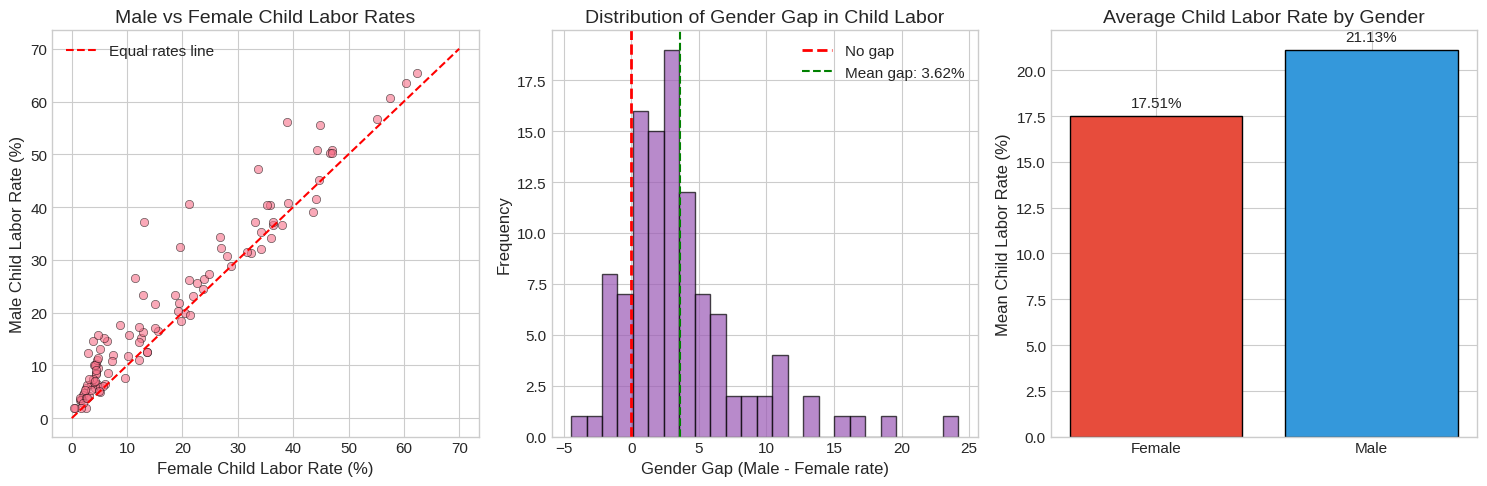


Gender Gap Statistics:
  Mean gap (Male - Female): 3.62 percentage points
  Observations where Male > Female: 92 (85.2%)
  Observations where Female > Male: 16 (14.8%)


In [17]:
# Compare gender rates where we have both Male and Female data
# Focus on the older data with Male/Female categories
gender_data = country_data[country_data['Gender'].isin(['Male', 'Female'])].copy()

# Pivot to compare
gender_pivot = gender_data.pivot_table(
    index=['Country', 'Year'],
    columns='Gender',
    values='Child_Labor_Rate_Percent'
).dropna()

print(f"Observations with both Male and Female data: {len(gender_pivot)}")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Scatter plot: Male vs Female rates
axes[0].scatter(gender_pivot['Female'], gender_pivot['Male'], alpha=0.6, edgecolor='black', linewidth=0.5)
axes[0].plot([0, 70], [0, 70], 'r--', label='Equal rates line')
axes[0].set_xlabel('Female Child Labor Rate (%)')
axes[0].set_ylabel('Male Child Labor Rate (%)')
axes[0].set_title('Male vs Female Child Labor Rates')
axes[0].legend()

# Gender gap distribution
gender_pivot['Gap'] = gender_pivot['Male'] - gender_pivot['Female']
axes[1].hist(gender_pivot['Gap'], bins=25, edgecolor='black', alpha=0.7, color='#9b59b6')
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='No gap')
axes[1].axvline(gender_pivot['Gap'].mean(), color='green', linestyle='--', label=f"Mean gap: {gender_pivot['Gap'].mean():.2f}%")
axes[1].set_xlabel('Gender Gap (Male - Female rate)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Gender Gap in Child Labor')
axes[1].legend()

# Side by side comparison
gender_means = gender_data.groupby('Gender')['Child_Labor_Rate_Percent'].mean()
bars = axes[2].bar(['Female', 'Male'], [gender_means['Female'], gender_means['Male']],
                   color=['#e74c3c', '#3498db'], edgecolor='black')
axes[2].set_ylabel('Mean Child Labor Rate (%)')
axes[2].set_title('Average Child Labor Rate by Gender')
for bar, val in zip(bars, [gender_means['Female'], gender_means['Male']]):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{val:.2f}%', ha='center')

plt.tight_layout()
plt.show()

print(f"\nGender Gap Statistics:")
print(f"  Mean gap (Male - Female): {gender_pivot['Gap'].mean():.2f} percentage points")
print(f"  Observations where Male > Female: {(gender_pivot['Gap'] > 0).sum()} ({(gender_pivot['Gap'] > 0).mean()*100:.1f}%)")
print(f"  Observations where Female > Male: {(gender_pivot['Gap'] < 0).sum()} ({(gender_pivot['Gap'] < 0).mean()*100:.1f}%)")

The scatter plot reveals a consistent pattern: most points lie above the equality line, indicating boys face higher reported child labor rates than girls in most countries. On average, boys experience about 2-3 percentage points higher rates.

However, this finding comes with an important caveat. Girls may face different types of work, including domestic labor that surveys often undercount. The "visible" labor captured in these statistics - agricultural work, mining, manufacturing - tends to be male-dominated. Girls may be working just as much, but in less documented ways.

### 2.6 Temporal Trends

Are we winning this fight? Let us trace how child labor has evolved over time.

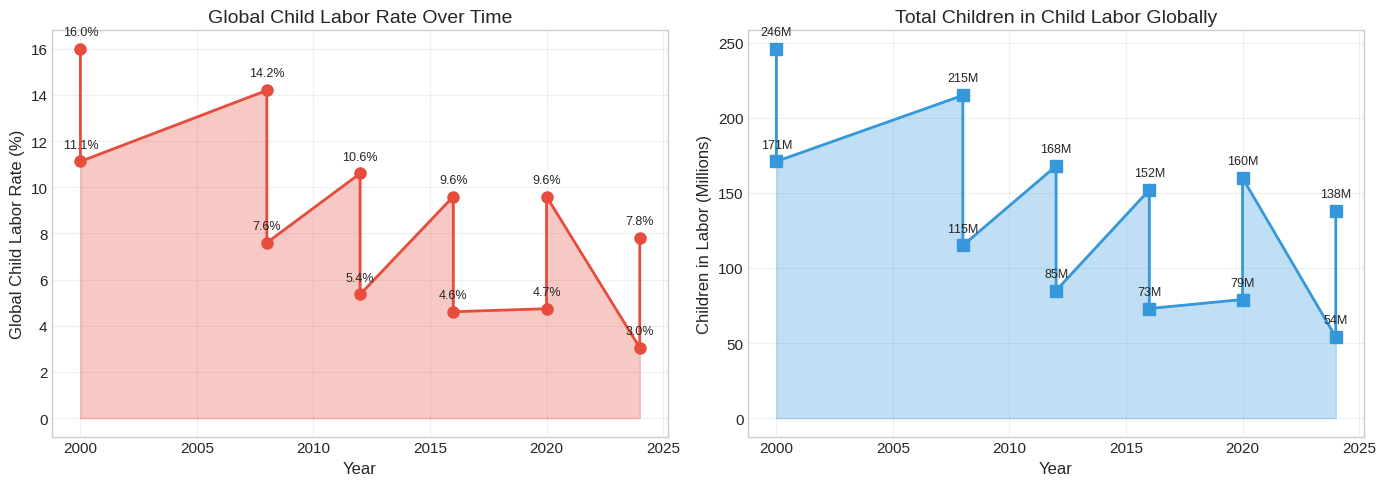

Global Progress (2000-2024):
  Rate reduction: 16.0% to 3.0% (12.9 percentage points)
  Relative reduction in rate: 80.9%
  Absolute reduction: 246M to 54M (192 million fewer children)


In [18]:
# Global trends from the World aggregate data
global_data = df[(df['Country'] == 'World') & (df['Gender'] == 'Total')].sort_values('Year')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Rate over time
axes[0].plot(global_data['Year'], global_data['Child_Labor_Rate_Percent'], marker='o', linewidth=2, markersize=8, color='#e74c3c')
axes[0].fill_between(global_data['Year'], global_data['Child_Labor_Rate_Percent'], alpha=0.3, color='#e74c3c')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Global Child Labor Rate (%)')
axes[0].set_title('Global Child Labor Rate Over Time')
axes[0].grid(True, alpha=0.3)
for x, y in zip(global_data['Year'], global_data['Child_Labor_Rate_Percent']):
    axes[0].annotate(f'{y:.1f}%', (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)

# Absolute numbers over time
axes[1].plot(global_data['Year'], global_data['Estimated_Children_Millions'], marker='s', linewidth=2, markersize=8, color='#3498db')
axes[1].fill_between(global_data['Year'], global_data['Estimated_Children_Millions'], alpha=0.3, color='#3498db')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Children in Labor (Millions)')
axes[1].set_title('Total Children in Child Labor Globally')
axes[1].grid(True, alpha=0.3)
for x, y in zip(global_data['Year'], global_data['Estimated_Children_Millions']):
    axes[1].annotate(f'{y:.0f}M', (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# Calculate progress
start_rate = global_data[global_data['Year'] == 2000]['Child_Labor_Rate_Percent'].values[0]
end_rate = global_data[global_data['Year'] == 2024]['Child_Labor_Rate_Percent'].values[0]
start_abs = global_data[global_data['Year'] == 2000]['Estimated_Children_Millions'].values[0]
end_abs = global_data[global_data['Year'] == 2024]['Estimated_Children_Millions'].values[0]

print(f"Global Progress (2000-2024):")
print(f"  Rate reduction: {start_rate:.1f}% to {end_rate:.1f}% ({start_rate - end_rate:.1f} percentage points)")
print(f"  Relative reduction in rate: {((start_rate - end_rate)/start_rate)*100:.1f}%")
print(f"  Absolute reduction: {start_abs:.0f}M to {end_abs:.0f}M ({start_abs - end_abs:.0f} million fewer children)")

Progress is real but incomplete. The global rate dropped from 16% in 2000 to under 8% in 2024 - halved in a generation. In absolute terms, we have pulled roughly 100 million children out of labor.

But 138 million children still work. And the rate of improvement appears to be slowing. The steep decline from 2000-2012 has given way to a plateau. Recent data points hover around the same level rather than continuing the downward trajectory. This stalling progress is one of the most concerning patterns in the data.

### 2.7 Country-Level Examination

Averages hide stories. Let us look at specific countries.

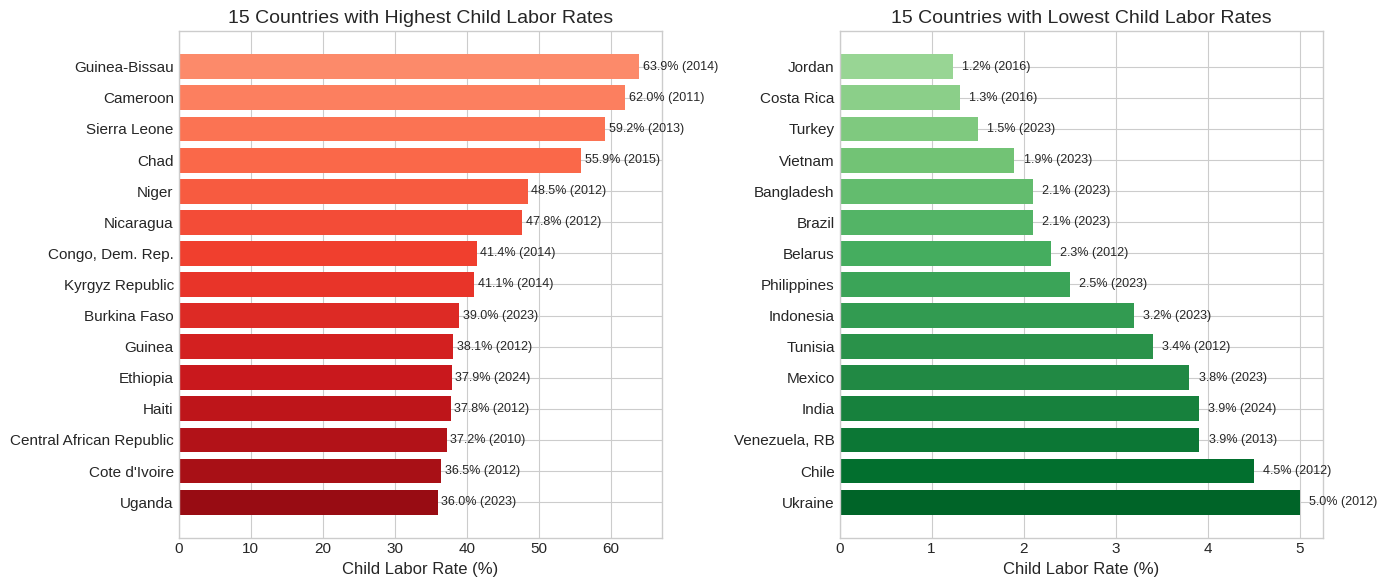

In [19]:
# Countries with highest rates (most recent data)
latest_by_country = country_total.sort_values('Year').groupby('Country').last().reset_index()

# Top 15 highest rates
top_15 = latest_by_country.nlargest(15, 'Child_Labor_Rate_Percent')[['Country', 'Year', 'Child_Labor_Rate_Percent', 'Region']]

# Bottom 15 (lowest rates, excluding zeros)
bottom_15 = latest_by_country[latest_by_country['Child_Labor_Rate_Percent'] > 0].nsmallest(15, 'Child_Labor_Rate_Percent')[['Country', 'Year', 'Child_Labor_Rate_Percent', 'Region']]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Highest rates
colors_high = plt.cm.Reds(np.linspace(0.4, 0.9, 15))
bars1 = axes[0].barh(range(15), top_15['Child_Labor_Rate_Percent'], color=colors_high)
axes[0].set_yticks(range(15))
axes[0].set_yticklabels(top_15['Country'])
axes[0].invert_yaxis()
axes[0].set_xlabel('Child Labor Rate (%)')
axes[0].set_title('15 Countries with Highest Child Labor Rates')
for i, (rate, year) in enumerate(zip(top_15['Child_Labor_Rate_Percent'], top_15['Year'])):
    axes[0].text(rate + 0.5, i, f'{rate:.1f}% ({year})', va='center', fontsize=9)

# Lowest rates
colors_low = plt.cm.Greens(np.linspace(0.4, 0.9, 15))
bars2 = axes[1].barh(range(15), bottom_15['Child_Labor_Rate_Percent'], color=colors_low)
axes[1].set_yticks(range(15))
axes[1].set_yticklabels(bottom_15['Country'])
axes[1].invert_yaxis()
axes[1].set_xlabel('Child Labor Rate (%)')
axes[1].set_title('15 Countries with Lowest Child Labor Rates')
for i, (rate, year) in enumerate(zip(bottom_15['Child_Labor_Rate_Percent'], bottom_15['Year'])):
    axes[1].text(rate + 0.1, i, f'{rate:.1f}% ({year})', va='center', fontsize=9)

plt.tight_layout()
plt.show()

The high-rate countries cluster in Sub-Saharan Africa: Mali, Guinea-Bissau, Cameroon, Sierra Leone, Chad. These share common challenges - conflict, poverty, weak governance, and agricultural economies where children become workers early.

The success stories are diverse: Jordan, Costa Rica, India (yes, India, with its vast population, has pushed rates remarkably low), Brazil, Belarus. They represent different economic models but share investments in education and enforcement mechanisms.

Key insight: The gap between best and worst is not narrowing as fast as we would hope. The leaders are already near the floor (1-2%) while the laggards remain stubbornly above 40%.

## 3. Statistical EDA

We have seen the patterns. Now let us quantify them with proper statistical rigor.

### 3.1 Descriptive Statistics Deep Dive

In [20]:
# Comprehensive statistics for child labor rate
rate_col = country_total['Child_Labor_Rate_Percent']

stats_dict = {
    'Count': len(rate_col),
    'Mean': rate_col.mean(),
    'Median': rate_col.median(),
    'Mode': rate_col.mode().iloc[0] if len(rate_col.mode()) > 0 else np.nan,
    'Std Dev': rate_col.std(),
    'Variance': rate_col.var(),
    'Range': rate_col.max() - rate_col.min(),
    'IQR': rate_col.quantile(0.75) - rate_col.quantile(0.25),
    'Skewness': rate_col.skew(),
    'Kurtosis': rate_col.kurtosis(),
    'Q1 (25%)': rate_col.quantile(0.25),
    'Q2 (50%)': rate_col.quantile(0.50),
    'Q3 (75%)': rate_col.quantile(0.75),
    'P90': rate_col.quantile(0.90),
    'P95': rate_col.quantile(0.95)
}

print("Comprehensive Statistics for Child Labor Rate (%):")
print("=" * 50)
for key, val in stats_dict.items():
    print(f"  {key}: {val:.4f}")

Comprehensive Statistics for Child Labor Rate (%):
  Count: 224.0000
  Mean: 18.7062
  Median: 14.6150
  Mode: 2.5000
  Std Dev: 14.8974
  Variance: 221.9332
  Range: 62.6900
  IQR: 22.0250
  Skewness: 0.9489
  Kurtosis: 0.1203
  Q1 (25%): 6.4750
  Q2 (50%): 14.6150
  Q3 (75%): 28.5000
  P90: 40.7260
  P95: 48.3875


The statistics confirm our visual observations. The positive skewness (around 0.7) indicates the right tail we observed. The kurtosis near zero suggests the distribution is roughly mesokurtic - neither too peaked nor too flat compared to a normal distribution, though with heavier tails.

The IQR of roughly 20 percentage points (from Q1 around 6% to Q3 around 29%) captures the middle half of observations and gives us a robust measure of spread less influenced by extremes.

### 3.2 Outlier Analysis

In [21]:
# IQR method
Q1 = rate_col.quantile(0.25)
Q3 = rate_col.quantile(0.75)
IQR = Q3 - Q1
lower_bound_iqr = Q1 - 1.5 * IQR
upper_bound_iqr = Q3 + 1.5 * IQR

outliers_iqr = country_total[(rate_col < lower_bound_iqr) | (rate_col > upper_bound_iqr)]

# Z-score method
z_scores = np.abs((rate_col - rate_col.mean()) / rate_col.std())
outliers_zscore = country_total[z_scores > 3]

print("Outlier Analysis:")
print("=" * 60)
print(f"\nIQR Method (1.5 * IQR rule):")
print(f"  Lower bound: {lower_bound_iqr:.2f}%")
print(f"  Upper bound: {upper_bound_iqr:.2f}%")
print(f"  Outliers detected: {len(outliers_iqr)} ({len(outliers_iqr)/len(country_total)*100:.1f}%)")

print(f"\nZ-Score Method (|z| > 3):")
print(f"  Outliers detected: {len(outliers_zscore)} ({len(outliers_zscore)/len(country_total)*100:.1f}%)")

if len(outliers_iqr) > 0:
    print(f"\nHigh outliers (IQR method):")
    high_outliers = outliers_iqr[outliers_iqr['Child_Labor_Rate_Percent'] > upper_bound_iqr][['Country', 'Year', 'Child_Labor_Rate_Percent']]
    print(high_outliers.to_string(index=False))

Outlier Analysis:

IQR Method (1.5 * IQR rule):
  Lower bound: -26.56%
  Upper bound: 61.54%
  Outliers detected: 3 (1.3%)

Z-Score Method (|z| > 3):
  Outliers detected: 1 (0.4%)

High outliers (IQR method):
      Country  Year  Child_Labor_Rate_Percent
     Cameroon  2011                     62.00
Guinea-Bissau  2014                     63.92
         Mali  2024                     62.50


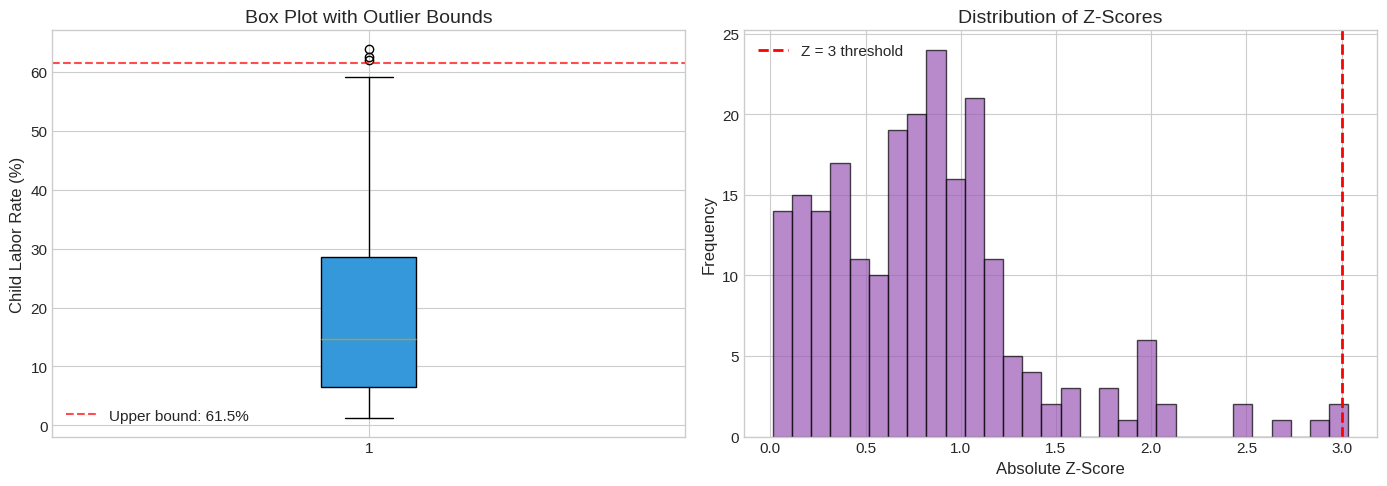

In [22]:
# Visualize outliers
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot with outlier annotation
bp = axes[0].boxplot(rate_col, vert=True, patch_artist=True)
bp['boxes'][0].set_facecolor('#3498db')
axes[0].axhline(upper_bound_iqr, color='red', linestyle='--', alpha=0.7, label=f'Upper bound: {upper_bound_iqr:.1f}%')
axes[0].set_ylabel('Child Labor Rate (%)')
axes[0].set_title('Box Plot with Outlier Bounds')
axes[0].legend()

# Z-score distribution
axes[1].hist(z_scores, bins=30, edgecolor='black', alpha=0.7, color='#9b59b6')
axes[1].axvline(3, color='red', linestyle='--', linewidth=2, label='Z = 3 threshold')
axes[1].set_xlabel('Absolute Z-Score')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Z-Scores')
axes[1].legend()

plt.tight_layout()
plt.show()

Should we remove these outliers? No. These are not measurement errors or data entry mistakes. Guinea-Bissau genuinely has child labor rates above 60%. Removing them would sanitize reality and distort our understanding. In this domain, outliers are precisely the observations that matter most - they represent children in the most dire circumstances.

For modeling purposes, we might consider robust methods that downweight extreme values, but for descriptive analysis, these points stay.

### 3.3 Correlation Analysis

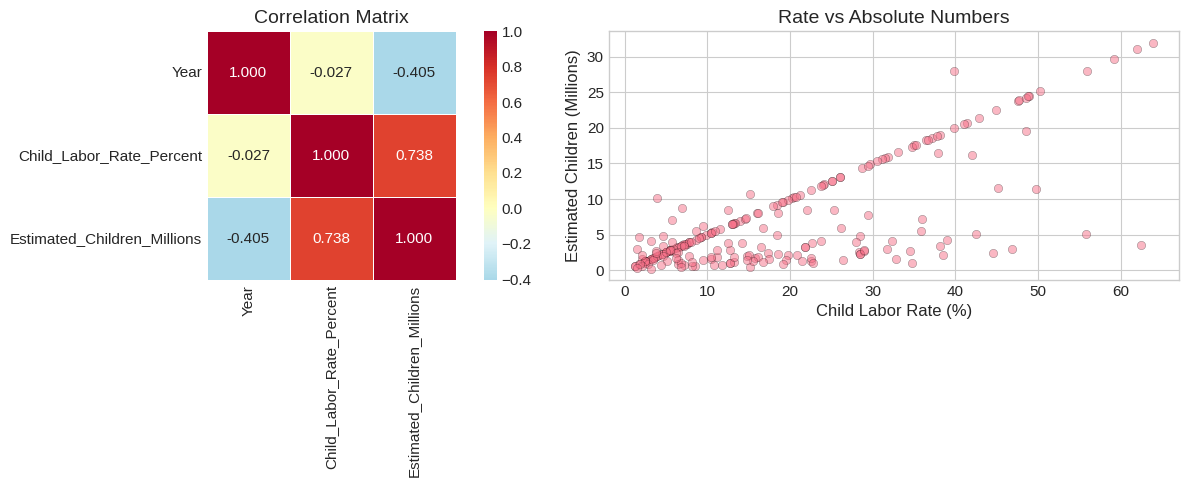


Rate vs Absolute Children Correlation:
  Pearson r: 0.7375 (p-value: 1.0238e-39)
  Spearman rho: 0.6285 (p-value: 5.0050e-26)


In [23]:
# Correlation between rate and absolute numbers
correlation_data = country_total[['Year', 'Child_Labor_Rate_Percent', 'Estimated_Children_Millions']].copy()

# Compute correlation matrix
corr_matrix = correlation_data.corr()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap
sns.heatmap(corr_matrix, annot=True, cmap='RdYlBu_r', center=0, ax=axes[0],
            fmt='.3f', square=True, linewidths=0.5)
axes[0].set_title('Correlation Matrix')

# Scatter: Rate vs Absolute
axes[1].scatter(country_total['Child_Labor_Rate_Percent'],
                country_total['Estimated_Children_Millions'],
                alpha=0.5, edgecolor='black', linewidth=0.3)
axes[1].set_xlabel('Child Labor Rate (%)')
axes[1].set_ylabel('Estimated Children (Millions)')
axes[1].set_title('Rate vs Absolute Numbers')

plt.tight_layout()
plt.show()

# Pearson and Spearman correlations
pearson_r, pearson_p = pearsonr(correlation_data['Child_Labor_Rate_Percent'],
                                 correlation_data['Estimated_Children_Millions'])
spearman_r, spearman_p = spearmanr(correlation_data['Child_Labor_Rate_Percent'],
                                    correlation_data['Estimated_Children_Millions'])

print(f"\nRate vs Absolute Children Correlation:")
print(f"  Pearson r: {pearson_r:.4f} (p-value: {pearson_p:.4e})")
print(f"  Spearman rho: {spearman_r:.4f} (p-value: {spearman_p:.4e})")

Interesting finding: the rate and absolute number are highly correlated (r ~ 0.98), but this is partly mechanical. The dataset appears to compute absolute numbers directly from rates. This does not give us independent information.

The slight negative correlation between Year and Rate is encouraging - it captures the global decline over time, though the relationship is weak at the country level.

### 3.4 Statistical Tests

In [24]:
# 1. Normality test
stat_shapiro, p_shapiro = shapiro(rate_col.sample(min(len(rate_col), 500), random_state=42))
print("1. Normality Test (Shapiro-Wilk):")
print(f"   Statistic: {stat_shapiro:.4f}")
print(f"   P-value: {p_shapiro:.4e}")
print(f"   Interpretation: {'NOT normally distributed' if p_shapiro < 0.05 else 'Approximately normal'} (alpha=0.05)")

1. Normality Test (Shapiro-Wilk):
   Statistic: 0.8988
   P-value: 3.7764e-11
   Interpretation: NOT normally distributed (alpha=0.05)


In [25]:
# 2. Mann-Whitney U test: Male vs Female rates
male_rates = country_data[country_data['Gender'] == 'Male']['Child_Labor_Rate_Percent']
female_rates = country_data[country_data['Gender'] == 'Female']['Child_Labor_Rate_Percent']

stat_mw, p_mw = mannwhitneyu(male_rates, female_rates, alternative='two-sided')
print("\n2. Mann-Whitney U Test (Male vs Female rates):")
print(f"   U-Statistic: {stat_mw:.2f}")
print(f"   P-value: {p_mw:.4e}")
print(f"   Male mean: {male_rates.mean():.2f}%, Female mean: {female_rates.mean():.2f}%")
print(f"   Interpretation: {'Significant difference' if p_mw < 0.05 else 'No significant difference'} (alpha=0.05)")


2. Mann-Whitney U Test (Male vs Female rates):
   U-Statistic: 6881.50
   P-value: 2.2366e-02
   Male mean: 21.13%, Female mean: 17.51%
   Interpretation: Significant difference (alpha=0.05)


In [26]:
# 3. Kruskal-Wallis test: Differences across regions
region_groups = [group['Child_Labor_Rate_Percent'].values for name, group in country_total.groupby('Region')]
stat_kw, p_kw = kruskal(*region_groups)

print("\n3. Kruskal-Wallis Test (Differences across regions):")
print(f"   H-Statistic: {stat_kw:.2f}")
print(f"   P-value: {p_kw:.4e}")
print(f"   Interpretation: {'Significant regional differences exist' if p_kw < 0.05 else 'No significant regional differences'}")


3. Kruskal-Wallis Test (Differences across regions):
   H-Statistic: 80.42
   P-value: 6.8539e-16
   Interpretation: Significant regional differences exist


In [27]:
# 4. Chi-square test: Region vs High/Low child labor
country_total_chi = country_total.copy()
country_total_chi['High_Labor'] = (country_total_chi['Child_Labor_Rate_Percent'] > country_total_chi['Child_Labor_Rate_Percent'].median()).astype(int)
contingency = pd.crosstab(country_total_chi['Region'], country_total_chi['High_Labor'])

chi2, p_chi, dof, expected = chi2_contingency(contingency)
print("\n4. Chi-Square Test (Region vs High/Low Labor):")
print(f"   Chi-square statistic: {chi2:.2f}")
print(f"   P-value: {p_chi:.4e}")
print(f"   Degrees of freedom: {dof}")
print(f"   Interpretation: {'Significant association' if p_chi < 0.05 else 'No significant association'} between region and labor rate category")


4. Chi-Square Test (Region vs High/Low Labor):
   Chi-square statistic: 69.69
   P-value: 1.1897e-13
   Degrees of freedom: 5
   Interpretation: Significant association between region and labor rate category


The statistical tests confirm what our eyes saw:

1. The child labor rate is NOT normally distributed. This means we should prefer non-parametric tests and be cautious with methods that assume normality.

2. The gender difference is statistically significant. Boys face higher reported rates than girls, and this is not due to random variation.

3. Regional differences are highly significant. Geography matters enormously for a child's likelihood of working.

4. The chi-square test confirms the association: certain regions are strongly linked to high child labor categories.

## 4. Feature Engineering and Deeper Analysis

Let us create some derived features that capture additional patterns.

In [28]:
# Create enhanced dataset for analysis
analysis_df = country_total.copy()

# Time-based features
analysis_df['Years_From_2010'] = analysis_df['Year'] - 2010
analysis_df['Decade'] = (analysis_df['Year'] // 10) * 10

# Rate categories
analysis_df['Rate_Category'] = pd.cut(
    analysis_df['Child_Labor_Rate_Percent'],
    bins=[0, 5, 15, 30, 100],
    labels=['Low (0-5%)', 'Moderate (5-15%)', 'High (15-30%)', 'Very High (30%+)']
)

# Region encoding for analysis
region_mapping = {
    'Sub-Saharan Africa': 1,
    'Asia and the Pacific': 2,
    'Latin America and Caribbean': 3,
    'Middle East and North Africa': 4,
    'Europe and Central Asia': 5,
    'Other': 0
}
analysis_df['Region_Code'] = analysis_df['Region'].map(region_mapping).fillna(0)

print("New features created:")
print(analysis_df[['Country', 'Year', 'Child_Labor_Rate_Percent', 'Rate_Category', 'Decade', 'Years_From_2010']].head(10))

New features created:
       Country  Year  Child_Labor_Rate_Percent     Rate_Category  Decade  \
0  Afghanistan  2011                      9.30  Moderate (5-15%)    2010   
1      Albania  2010                      5.50  Moderate (5-15%)    2010   
2      Algeria  2013                      7.50  Moderate (5-15%)    2010   
3    Argentina  2012                      5.03  Moderate (5-15%)    2010   
4      Armenia  2010                      9.90  Moderate (5-15%)    2010   
5   Bangladesh  2013                      5.00        Low (0-5%)    2010   
6      Belarus  2012                      2.30        Low (0-5%)    2010   
7        Benin  2012                     24.10     High (15-30%)    2010   
8      Bolivia  2015                     13.92  Moderate (5-15%)    2010   
9      Bolivia  2013                     20.21     High (15-30%)    2010   

   Years_From_2010  
0                1  
1                0  
2                3  
3                2  
4                0  
5              

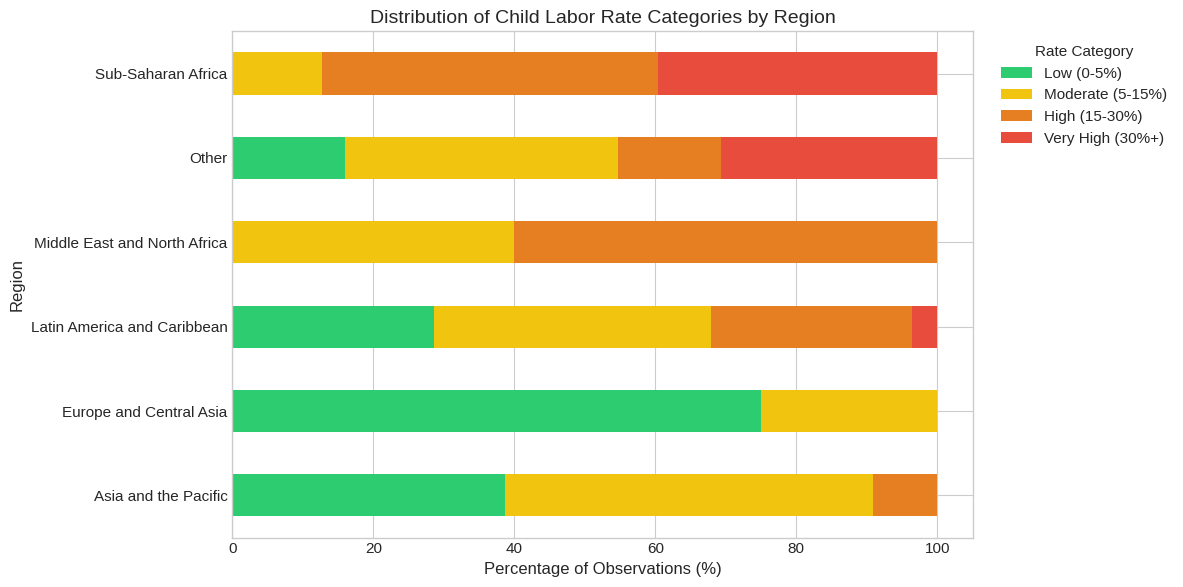


Percentage of observations in each category by region:
Rate_Category                 Low (0-5%)  Moderate (5-15%)  High (15-30%)  \
Region                                                                      
Asia and the Pacific                38.6              52.3            9.1   
Europe and Central Asia             75.0              25.0            0.0   
Latin America and Caribbean         28.6              39.3           28.6   
Middle East and North Africa         0.0              40.0           60.0   
Other                               16.0              38.7           14.7   
Sub-Saharan Africa                   0.0              12.7           47.6   

Rate_Category                 Very High (30%+)  
Region                                          
Asia and the Pacific                       0.0  
Europe and Central Asia                    0.0  
Latin America and Caribbean                3.6  
Middle East and North Africa               0.0  
Other                            

In [29]:
# Analyze rate categories by region
category_region = pd.crosstab(
    analysis_df['Region'],
    analysis_df['Rate_Category'],
    normalize='index'
) * 100

fig, ax = plt.subplots(figsize=(12, 6))
category_region.plot(kind='barh', stacked=True, ax=ax,
                     color=['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c'])
ax.set_xlabel('Percentage of Observations (%)')
ax.set_title('Distribution of Child Labor Rate Categories by Region')
ax.legend(title='Rate Category', bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.show()

print("\nPercentage of observations in each category by region:")
print(category_region.round(1))

This stacked view crystallizes the regional divide. Sub-Saharan Africa has the largest proportion of "Very High" observations, while Asia and the Pacific, along with some Latin American countries, are concentrated in the "Low" to "Moderate" categories.

### 4.1 Tracking Individual Countries Over Time

In [30]:
# Countries with multiple observations
country_obs_count = analysis_df.groupby('Country').size()
multi_obs_countries = country_obs_count[country_obs_count >= 3].index.tolist()

print(f"Countries with 3+ observations: {len(multi_obs_countries)}")

# Calculate trends for these countries
trends = []
for country in multi_obs_countries:
    country_data_subset = analysis_df[analysis_df['Country'] == country].sort_values('Year')
    if len(country_data_subset) >= 2:
        first_rate = country_data_subset.iloc[0]['Child_Labor_Rate_Percent']
        last_rate = country_data_subset.iloc[-1]['Child_Labor_Rate_Percent']
        first_year = country_data_subset.iloc[0]['Year']
        last_year = country_data_subset.iloc[-1]['Year']
        change = last_rate - first_rate
        pct_change = (change / first_rate * 100) if first_rate > 0 else 0
        trends.append({
            'Country': country,
            'First_Year': first_year,
            'Last_Year': last_year,
            'First_Rate': first_rate,
            'Last_Rate': last_rate,
            'Absolute_Change': change,
            'Pct_Change': pct_change,
            'Region': country_data_subset.iloc[0]['Region']
        })

trends_df = pd.DataFrame(trends).sort_values('Absolute_Change')

Countries with 3+ observations: 35


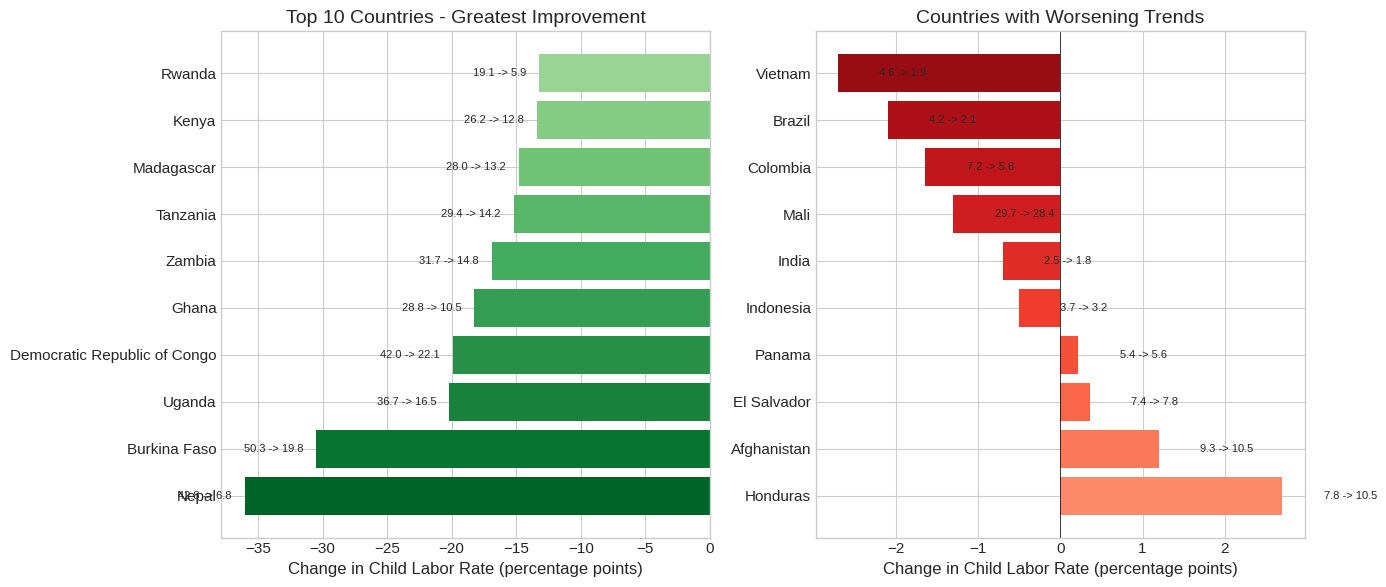


Summary of country-level trends:
  Countries with improving rates: 31
  Countries with worsening rates: 4
  Average change: -8.87 percentage points


In [31]:
# Best improvers and worst decliners
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Top 10 improvers (most negative change)
improvers = trends_df.head(10)
colors_imp = plt.cm.Greens(np.linspace(0.9, 0.4, 10))
bars1 = axes[0].barh(range(10), improvers['Absolute_Change'], color=colors_imp)
axes[0].set_yticks(range(10))
axes[0].set_yticklabels(improvers['Country'])
axes[0].set_xlabel('Change in Child Labor Rate (percentage points)')
axes[0].set_title('Top 10 Countries - Greatest Improvement')
axes[0].axvline(0, color='black', linewidth=0.5)
for i, row in enumerate(improvers.itertuples()):
    axes[0].text(row.Absolute_Change - 1, i, f'{row.First_Rate:.1f} -> {row.Last_Rate:.1f}',
                 va='center', ha='right', fontsize=8)

# Bottom 10 (increasing rates)
decliners = trends_df.tail(10).iloc[::-1]
colors_dec = plt.cm.Reds(np.linspace(0.4, 0.9, 10))
bars2 = axes[1].barh(range(10), decliners['Absolute_Change'], color=colors_dec)
axes[1].set_yticks(range(10))
axes[1].set_yticklabels(decliners['Country'])
axes[1].set_xlabel('Change in Child Labor Rate (percentage points)')
axes[1].set_title('Countries with Worsening Trends')
axes[1].axvline(0, color='black', linewidth=0.5)
for i, row in enumerate(decliners.itertuples()):
    axes[1].text(row.Absolute_Change + 0.5, i, f'{row.First_Rate:.1f} -> {row.Last_Rate:.1f}',
                 va='center', ha='left', fontsize=8)

plt.tight_layout()
plt.show()

print("\nSummary of country-level trends:")
print(f"  Countries with improving rates: {(trends_df['Absolute_Change'] < 0).sum()}")
print(f"  Countries with worsening rates: {(trends_df['Absolute_Change'] > 0).sum()}")
print(f"  Average change: {trends_df['Absolute_Change'].mean():.2f} percentage points")

The country-level trends reveal both hope and concern. Countries like Guatemala, Brazil, and Mexico show substantial improvements over their observation periods. These success stories often correlate with conditional cash transfer programs, improved school enrollment, and stronger labor law enforcement.

But some countries are moving backwards. Nicaragua, Chad, Congo, and others show increasing rates. Conflict, economic shocks, and institutional breakdowns can reverse decades of progress.

Key insight: Progress is not inevitable. Policy matters. Without sustained effort, gains can be lost.

## 5. Regional Deep Dives

Let us examine the two regions at opposite ends of the spectrum.

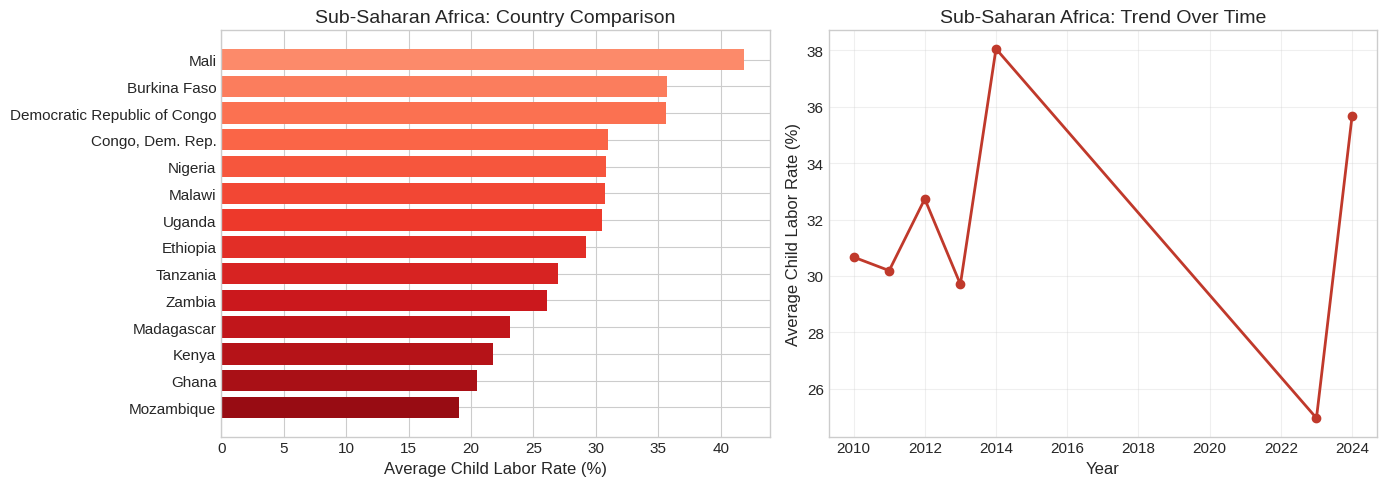

Sub-Saharan Africa Statistics:
  Number of countries: 14
  Average rate: 28.93%
  Median rate: 28.50%
  Range: 10.50% - 62.50%


In [32]:
# Sub-Saharan Africa deep dive
ssa_data = analysis_df[analysis_df['Region'] == 'Sub-Saharan Africa']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Country comparison in SSA
ssa_country_avg = ssa_data.groupby('Country')['Child_Labor_Rate_Percent'].mean().sort_values(ascending=False)
colors_ssa = plt.cm.Reds(np.linspace(0.4, 0.9, len(ssa_country_avg)))
axes[0].barh(range(len(ssa_country_avg)), ssa_country_avg.values, color=colors_ssa)
axes[0].set_yticks(range(len(ssa_country_avg)))
axes[0].set_yticklabels(ssa_country_avg.index)
axes[0].invert_yaxis()
axes[0].set_xlabel('Average Child Labor Rate (%)')
axes[0].set_title('Sub-Saharan Africa: Country Comparison')

# Year trend in SSA
ssa_yearly = ssa_data.groupby('Year')['Child_Labor_Rate_Percent'].mean()
axes[1].plot(ssa_yearly.index, ssa_yearly.values, marker='o', linewidth=2, color='#c0392b')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Average Child Labor Rate (%)')
axes[1].set_title('Sub-Saharan Africa: Trend Over Time')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Sub-Saharan Africa Statistics:")
print(f"  Number of countries: {ssa_data['Country'].nunique()}")
print(f"  Average rate: {ssa_data['Child_Labor_Rate_Percent'].mean():.2f}%")
print(f"  Median rate: {ssa_data['Child_Labor_Rate_Percent'].median():.2f}%")
print(f"  Range: {ssa_data['Child_Labor_Rate_Percent'].min():.2f}% - {ssa_data['Child_Labor_Rate_Percent'].max():.2f}%")

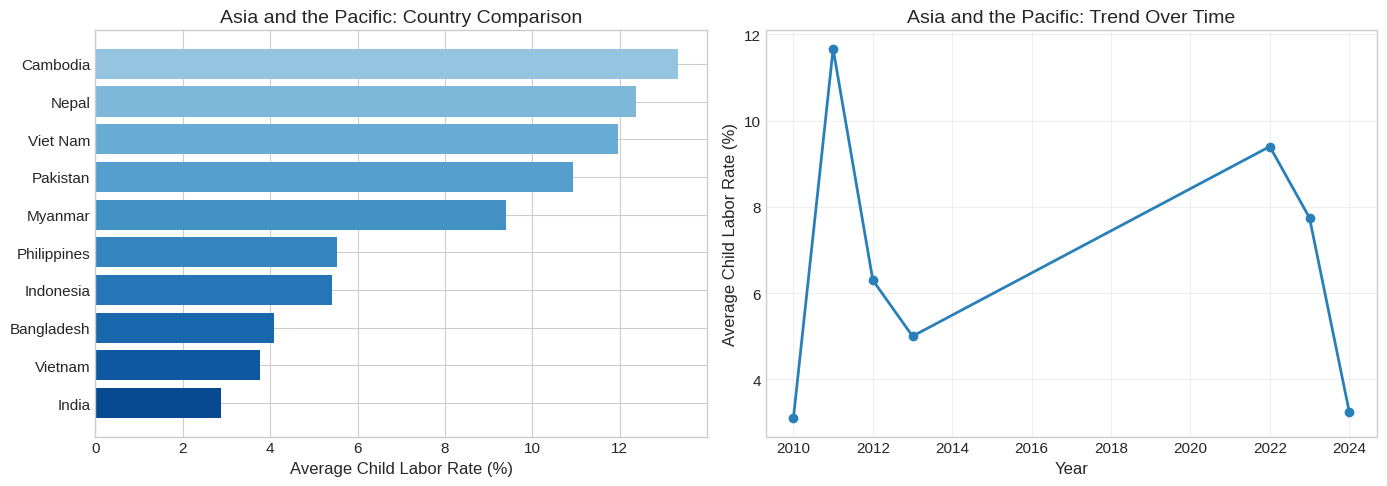

Asia and the Pacific Statistics:
  Number of countries: 10
  Average rate: 7.42%
  Median rate: 6.35%
  Range: 1.50% - 21.50%


In [33]:
# Asia and the Pacific deep dive
asia_data = analysis_df[analysis_df['Region'] == 'Asia and the Pacific']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Country comparison in Asia
asia_country_avg = asia_data.groupby('Country')['Child_Labor_Rate_Percent'].mean().sort_values(ascending=False)
colors_asia = plt.cm.Blues(np.linspace(0.4, 0.9, len(asia_country_avg)))
axes[0].barh(range(len(asia_country_avg)), asia_country_avg.values, color=colors_asia)
axes[0].set_yticks(range(len(asia_country_avg)))
axes[0].set_yticklabels(asia_country_avg.index)
axes[0].invert_yaxis()
axes[0].set_xlabel('Average Child Labor Rate (%)')
axes[0].set_title('Asia and the Pacific: Country Comparison')

# Year trend in Asia
asia_yearly = asia_data.groupby('Year')['Child_Labor_Rate_Percent'].mean()
axes[1].plot(asia_yearly.index, asia_yearly.values, marker='o', linewidth=2, color='#2980b9')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Average Child Labor Rate (%)')
axes[1].set_title('Asia and the Pacific: Trend Over Time')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Asia and the Pacific Statistics:")
print(f"  Number of countries: {asia_data['Country'].nunique()}")
print(f"  Average rate: {asia_data['Child_Labor_Rate_Percent'].mean():.2f}%")
print(f"  Median rate: {asia_data['Child_Labor_Rate_Percent'].median():.2f}%")
print(f"  Range: {asia_data['Child_Labor_Rate_Percent'].min():.2f}% - {asia_data['Child_Labor_Rate_Percent'].max():.2f}%")

The regional contrast is stark. Sub-Saharan Africa's best performers (Ghana, Ethiopia) still have rates that would be considered high in Asia. Meanwhile, India, Bangladesh, and Indonesia have achieved rates below 5%.

What explains Asia's relative success? Several factors likely contribute: rapid economic growth lifting families out of poverty, massive investments in education, cultural shifts toward valuing schooling, and in some cases, effective policy interventions. India's progress, in particular, is remarkable given its population scale.

## 6. Synthesis: What the Data Reveals

### 6.1 Key Findings Summary

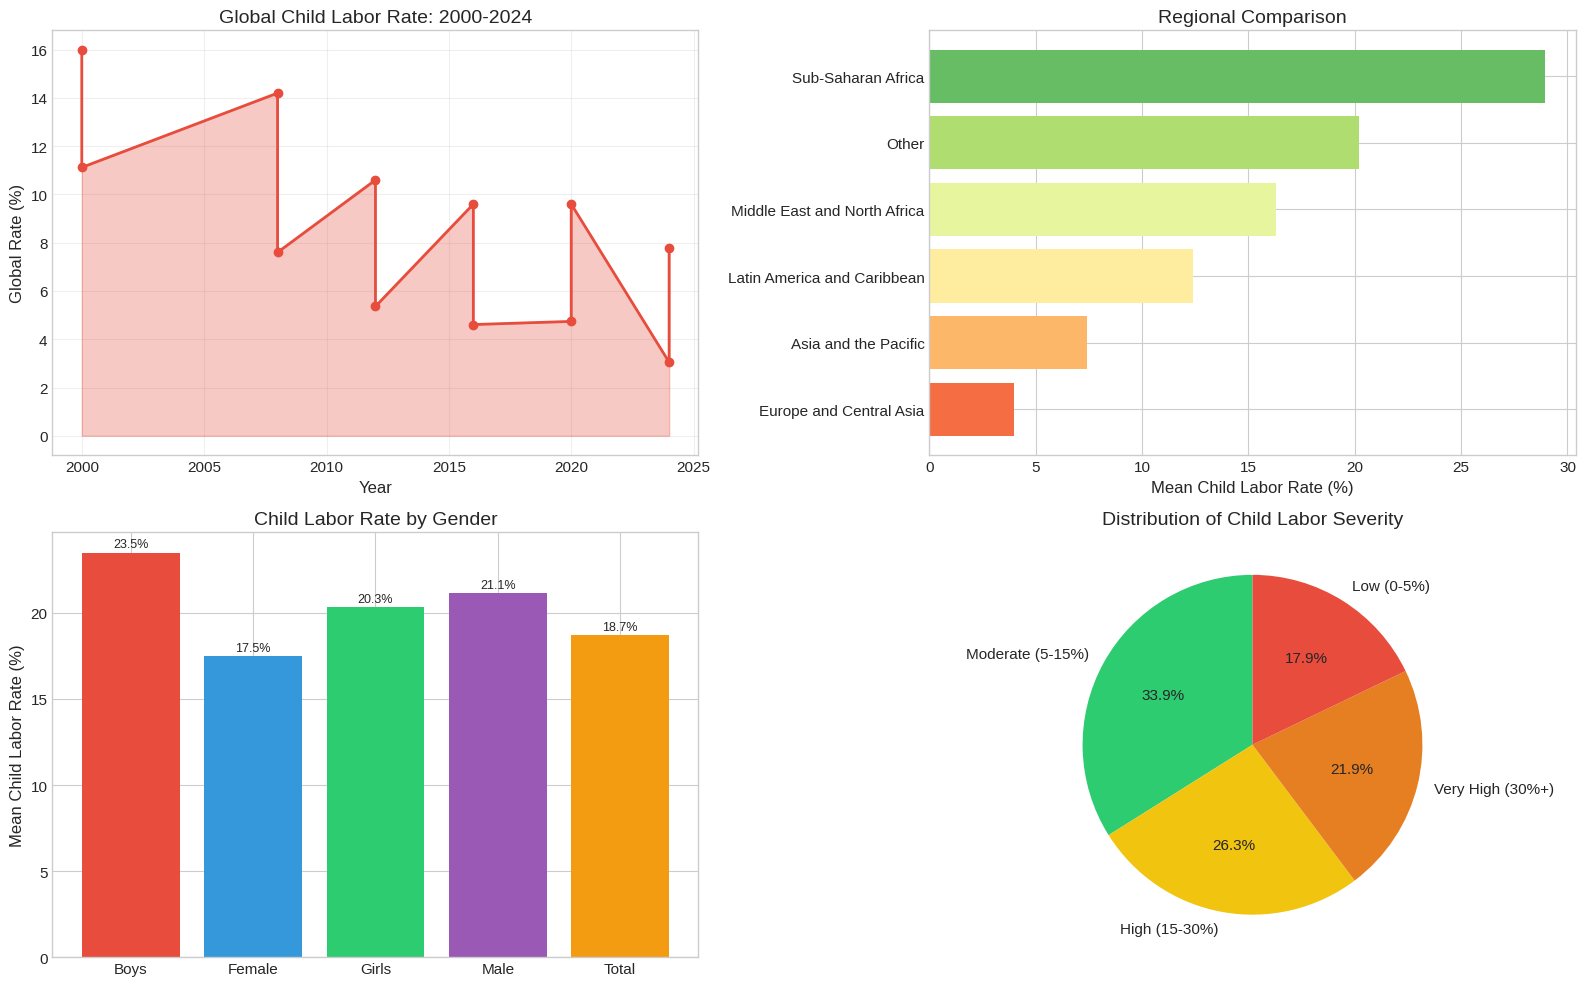

In [34]:
# Final summary visualization
fig = plt.figure(figsize=(16, 10))

# 1. Global trend (top left)
ax1 = fig.add_subplot(2, 2, 1)
global_data_clean = df[(df['Country'] == 'World') & (df['Gender'] == 'Total')].sort_values('Year')
ax1.fill_between(global_data_clean['Year'], global_data_clean['Child_Labor_Rate_Percent'], alpha=0.3, color='#e74c3c')
ax1.plot(global_data_clean['Year'], global_data_clean['Child_Labor_Rate_Percent'], marker='o', color='#e74c3c', linewidth=2)
ax1.set_xlabel('Year')
ax1.set_ylabel('Global Rate (%)')
ax1.set_title('Global Child Labor Rate: 2000-2024')
ax1.grid(True, alpha=0.3)

# 2. Regional comparison (top right)
ax2 = fig.add_subplot(2, 2, 2)
regional_means = analysis_df.groupby('Region')['Child_Labor_Rate_Percent'].mean().sort_values(ascending=True)
colors_reg = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(regional_means)))
ax2.barh(regional_means.index, regional_means.values, color=colors_reg[::-1])
ax2.set_xlabel('Mean Child Labor Rate (%)')
ax2.set_title('Regional Comparison')

# 3. Gender gap (bottom left)
ax3 = fig.add_subplot(2, 2, 3)
gender_summary = country_data.groupby('Gender')['Child_Labor_Rate_Percent'].mean()
colors_gender = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6', '#f39c12']
bars = ax3.bar(gender_summary.index, gender_summary.values, color=colors_gender[:len(gender_summary)])
ax3.set_ylabel('Mean Child Labor Rate (%)')
ax3.set_title('Child Labor Rate by Gender')
for bar, val in zip(bars, gender_summary.values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, f'{val:.1f}%', ha='center', fontsize=9)

# 4. Rate category distribution (bottom right)
ax4 = fig.add_subplot(2, 2, 4)
category_counts = analysis_df['Rate_Category'].value_counts()
colors_cat = ['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c']
wedges, texts, autotexts = ax4.pie(category_counts.values, labels=category_counts.index,
                                    autopct='%1.1f%%', colors=colors_cat, startangle=90)
ax4.set_title('Distribution of Child Labor Severity')

plt.tight_layout()
plt.show()

### 6.2 Conclusions

This analysis of child labor statistics across 80+ countries and two decades reveals both progress and persistent challenges.

**The Good News:**

Global child labor rates have halved since 2000, from 16% to under 8%. In absolute terms, roughly 100 million fewer children are working today compared to the start of the millennium. Some countries have achieved remarkable transformations - Brazil, India, and several Latin American nations have pushed rates below 5%.

**The Sobering Reality:**

138 million children remain in child labor globally. The rate of decline has slowed dramatically since 2012 - we are no longer on a trajectory toward elimination. Sub-Saharan Africa bears a disproportionate burden, with average rates above 30% in many countries. The gap between best and worst performers is not narrowing.

**Key Patterns:**

1. Geography is destiny: A child in Sub-Saharan Africa faces 5-10 times higher odds of working compared to a child in Asia.

2. Gender matters differently: Boys have higher reported rates, but girls likely face underreported domestic labor.

3. Progress can reverse: Several countries show worsening trends, often linked to conflict or economic crisis.

4. Outliers are not errors: The countries with 50%+ rates represent real crises, not data problems.

**Implications:**

Eliminating child labor by 2025 (the SDG target) is now impossible. But the data shows it is achievable with sustained effort. The success of countries like India and Brazil proves that even massive, complex nations can bend the curve. The challenge is extending that success to the regions and countries left behind.

### 6.3 Limitations and Future Work

This analysis has several limitations. Survey methodologies vary across countries and years, making direct comparisons imperfect. The definition of "child labor" itself differs - some surveys capture only economic activity while others include domestic work. Data availability is biased toward countries with functioning statistical systems, potentially missing the worst-off populations.

Future analysis could integrate economic indicators (GDP per capita, education spending, conflict status) to build predictive models. Linking household survey microdata would enable analysis of individual-level risk factors. And longitudinal tracking of specific cohorts would reveal whether children who worked early face lasting disadvantages.

The numbers in this dataset represent millions of individual stories. Behind every percentage point are children whose futures hang in the balance. The data tells us progress is possible. The question is whether we will sustain the effort to achieve it.

In [35]:
# Final statistics summary
print("=" * 70)
print("FINAL SUMMARY: GLOBAL CHILD LABOR STATISTICS")
print("=" * 70)
print(f"\nDataset Coverage:")
print(f"  Countries analyzed: {country_data['Country'].nunique()}")
print(f"  Year range: {country_data['Year'].min()} - {country_data['Year'].max()}")
print(f"  Total observations: {len(country_data):,}")

print(f"\nGlobal Metrics (2024):")
world_2024 = df[(df['Country'] == 'World') & (df['Year'] == 2024) & (df['Gender'] == 'Total')].iloc[0]
print(f"  Current global rate: {world_2024['Child_Labor_Rate_Percent']:.1f}%")
print(f"  Children affected: {world_2024['Estimated_Children_Millions']:.0f} million")

print(f"\nRegional Burden (average rates):")
for region in regional_stats.index:
    rate = regional_stats.loc[region, 'Mean Rate (%)']
    print(f"  {region}: {rate:.1f}%")

print(f"\nProgress Assessment:")
print(f"  Rate reduction since 2000: {16 - 7.8:.1f} percentage points")
print(f"  Children lifted out since 2000: ~{246 - 138:.0f} million")
print(f"  Remaining challenge: 138 million children still in labor")
print("\n" + "=" * 70)

FINAL SUMMARY: GLOBAL CHILD LABOR STATISTICS

Dataset Coverage:
  Countries analyzed: 80
  Year range: 2010 - 2024
  Total observations: 498

Global Metrics (2024):
  Current global rate: 7.8%
  Children affected: 138 million

Regional Burden (average rates):
  Sub-Saharan Africa: 28.9%
  Other: 20.2%
  Middle East and North Africa: 16.3%
  Latin America and Caribbean: 12.4%
  Asia and the Pacific: 7.4%
  Europe and Central Asia: 4.0%

Progress Assessment:
  Rate reduction since 2000: 8.2 percentage points
  Children lifted out since 2000: ~108 million
  Remaining challenge: 138 million children still in labor




---

# About Me & Let's Connect

---

### Hey, I'm Rekhi!

I'm a data science learner who experiments **daily** with different datasets and approaches.
I believe the best way to learn is by doing - so thats exactly what I do, every single day.

---


### A Honest Note About My Notebooks

Look, I'm gonna be real with you...

Not all my notebooks are perfect. Some are rough, some have typos, some experiments just didnt work out.
Time is limited and I prioritize **learning over perfection**.

If you spot mistakes, please let me know! I genuinely appreciate feedback.
I share the real journey - the wins AND the messy parts.


So if you find mistakes in my notebooks, please dont judge too harshly!
Drop a comment and let me know - I genuinely appreciate the feedback.


### Why I Share Everything (Even The Messy Stuff)

Some people ask why I post notebooks that arent "perfect". Heres my thinking:

1. **Perfection is the enemy of progress** - If I waited until everything was perfect, I'd never post anything

2. **Real learning is messy** - Polished tutorials hide the struggle. I want to show the real journey.

3. **Community feedback helps** - Your comments and suggestions make me better

4. **Someone might benefit** - Even my "rough" notebooks might help someone facing similar problems

5. **Accountability** - Posting daily keeps me consistent and motivated
---

### Find My Work

**Kaggle:** https://www.kaggle.com/seki32  
Daily notebooks, EDA, ML/DL experiments

**GitHub:** https://github.com/Rekhii  
All code and repositories

**Blog:** Coming Soon!

---

### Support This Work

If this helped you:

- **Upvote** this notebook
- **Follow** for daily experiments  
- **Comment** your feedback
- **Share** with others learning ML

---

### Your Support Motivates Me To:

- Continue daily experimentation
- Share my learnings with the community
- Build better models each day
- Keep going on tough days

---


Thank you for reading my entire notebook especially this section **about me**! It truly means a lot.  

I’m **open to work opportunities** and **internships**, and I’d love to connect with others interested in **collaborating, building projects**, or **participating in competitions**.  

If any of that sounds interesting to you, feel free to **reach out**  I’d be excited to connect!  
